The following notebook is for generating plots for Lucas DMS project

It will be use code from different notebooks all located in this folder

In [1]:
#Loading nessesary libraries


import os
import random

from Bio import SeqIO
from IPython.display import display, Image

import matplotlib.pyplot as plt

import numpy as np

import pandas as pd

import dmslogo

import seaborn as sns




In [2]:
#Loading the data
#Here we are using the modified DMS_file containing different identifiers such as immunization, conditions and immunization status

fasta_file = r'c:\Users\au649453\OneDrive - Aarhus universitet\PhD\Luca\RBD_wuhan.fasta'

# Read the FASTA file
for record in SeqIO.parse(fasta_file, "fasta"):
    wuhan_sequence = str(record.seq)
    break  # Assuming there's only one sequence in the FASTA file


file_path = r'c:\Users\au649453\OneDrive - Aarhus universitet\PhD\Luca\summary_DMS_cleaned.xlsx'

df_total = pd.read_excel(file_path, usecols=["DMS_RBD_AS_position", "Spike_AS_Position", "Count_of_Base", "Amino_Acid", "Type_of_Mutation", "Enrichment_Ratio", "barcode", "immunization", "condition", "Total_Reads"])

# Subtract 5 to every position of Spike_AS_Position. (In excel sheets this starts at 336, instead of 331) I could also just have fixed the excel sheets. 
df_total["Spike_AS_Position"] = df_total["Spike_AS_Position"] - 5

#Removing ~5000 datapoints with "inf" values in the Enrichment_Ratio column and discarding reads with less than 10.000 total reads
df_total = df_total.dropna(subset=['Enrichment_Ratio','Amino_Acid'])

df_total = df_total[df_total["Total_Reads"] > 10000]

immunization = "Wuhan_Sequence"
barcode = "Wuhan_Barcode"

data_wuhan = []
for position, amino_acid in enumerate(wuhan_sequence, start=1):
    data_wuhan.append({
        'DMS_RBD_AS_position': position,
        'Spike_AS_Position': position + 330,
        'Amino_Acid': amino_acid,
        'immunization': immunization,
        'barcode': barcode,
        'Enrichment_Ratio': 1,# Assuming an enrichment ratio of 1 for simplicity
    })

## Create a DataFrame
df_wuhan = pd.DataFrame(data_wuhan)


df_total = pd.concat([df_total, df_wuhan], ignore_index=True)



In [ ]:
# Calculate the averages of Count_of_Base for the SYNOM and NON-SYNOM groups
average_counts = df_total.groupby('Type_of_Mutation')['Count_of_Base'].mean()
average_enrichment = df_total.groupby('Type_of_Mutation')['Enrichment_Ratio'].mean()

# Print the results
print("Average Count_of_Base for SYNOM group:", average_counts.get('SYNOM', 'N/A'))
print("Average Count_of_Base for NON-SYNOM group:", average_counts.get('NON-SYNOM', 'N/A'))

print("Average Enrichment_Ratio for SYNOM group:", average_enrichment.get('SYNOM', 'N/A'))
print("Average Enrichment_Ratio for NON-SYNOM group:", average_enrichment.get('NON-SYNOM', 'N/A'))

# Further subset into different immunization groups
immunization_groups = df_total['immunization'].unique()
for group in immunization_groups:
    if pd.notna(group):
        group_df = df_total[df_total['immunization'] == group]
        group_avg_counts = group_df.groupby('Type_of_Mutation')['Count_of_Base'].mean()
        print(f"\nAverage Count_of_Base for {group} - SYNOM group:", group_avg_counts.get('SYNOM', 'N/A'))
        print(f"Average Count_of_Base for {group} - NON-SYNOM group:", group_avg_counts.get('NON-SYNOM', 'N/A'))

# Calculate the standard deviations of Count_of_Base for the SYNOM and NON-SYNOM groups
std_devs = df_total.groupby('Type_of_Mutation')['Count_of_Base'].std()

# Print the results
print("Standard Deviation of Count_of_Base for SYNOM group:", std_devs.get('SYNOM', 'N/A'))
print("Standard Deviation of Count_of_Base for NON-SYNOM group:", std_devs.get('NON-SYNOM', 'N/A'))


The following code is generating logo plots for each group of conditions (Neutralizing Ab, Polyclonal Ab, "Library" and cells from mice immunized with either WT RBD or mutant RBD)

Following codeblock will generate lineplots for each condition

Library_ctrl
Mutant_RBD
Neutralizing_Ab
Polyclonal_Ab
wildtype_RBD


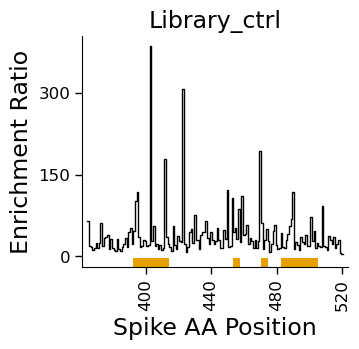

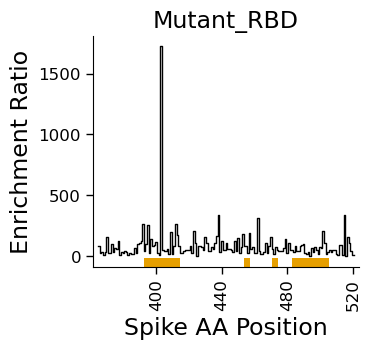

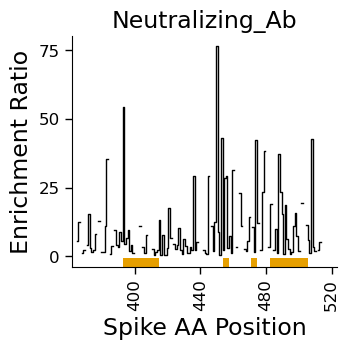

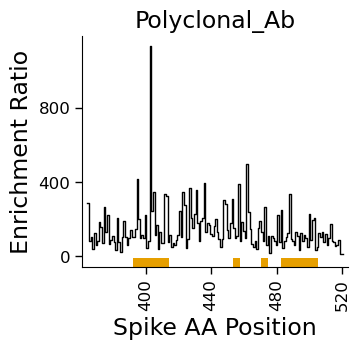

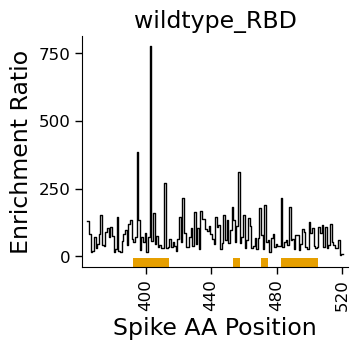

In [ ]:
#CODE FOR GENERATING LINEPLOTS WITH ENTIRE SEQUNCE, AND WITH HIGHLIGHTS
#Swap out barcode for barcode to do individual droplet analysis 

df_filtered = df_total[(df_total['Spike_AS_Position'] > 33+331) & (df_total['Type_of_Mutation'] == 'NON-SYNOM')] #Removes the first 33 positions due to bad read quality

df_filtered_agg = df_filtered.groupby(['Spike_AS_Position', 'Amino_Acid', 'barcode'], as_index=False).agg({
    'Enrichment_Ratio': 'sum'
})

#The positions that have showed high enrichment ratios in the library droplets are discarded from the analysis (pos 33, 72, 81 and 151)
sites_to_show = map(
    str,
    #[(i+331) for i in range(30, 200) if i not in [33, 72, 81, 151]] +  
    [455, 456, 472, 473, 484, 485, 486, 490, 496, 499] + #RBD-ACE2 interface according to article
    list(range(394,414)) + #R21 peptide sequnce with high affinity
    list(range(484, 505)) #R13 peptide sequence with high affinity
)
df_filtered_agg = df_filtered_agg.assign(
    site_label=lambda x: x["Amino_Acid"] + "_" + x["Spike_AS_Position"].astype(str),
    show_site=lambda x: x["Spike_AS_Position"].astype(str).isin(sites_to_show)
)

output_dir = "immunization_csv_files"
os.makedirs(output_dir, exist_ok=True)


for immunization in df_filtered_agg['immunization'].unique():
    print(immunization)
    df_filtered_im = df_filtered_agg.query(f'immunization == "{immunization}"')#.query("show_site")
    
    # Aggregate the data to ensure unique Spike_AS_Position values
    df_filtered_im = df_filtered_im.groupby('Spike_AS_Position', as_index=False).agg({
        'Enrichment_Ratio': 'sum',
    })
    
    csv_file_path = os.path.join(output_dir, f"{immunization}_data.csv")
    df_filtered_im.to_csv(csv_file_path, index=False)


    df_filtered_im = df_filtered_im.set_index('Spike_AS_Position').reindex(range(df_filtered_im['Spike_AS_Position'].min(), df_filtered['Spike_AS_Position'].max() + 1)).reset_index()
    
    # Merge the show_site column back into df_filtered
    df_filtered_im = df_filtered_im.merge(df_filtered_agg[['Spike_AS_Position', 'show_site']], on='Spike_AS_Position', how='left')

    fig, ax = dmslogo.line.draw_line(
        df_filtered_im,
        x_col="Spike_AS_Position",
        height_col="Enrichment_Ratio",
        title=immunization,
        xlabel="Spike AA Position",
        ylabel="Enrichment Ratio",
        show_col="show_site"
    )
    

    
    # Save the figure
    #file_path = os.path.join(r"C:\Users\au649453\OneDrive - Aarhus universitet\PhD\Luca\DMS_plots\Enriched and targeted positions", f"{immunization}_lineplots.png")
    #plt.savefig(file_path, dpi = 300, bbox_inches = 'tight')
    #plt.close(fig)
    #plt.show()


Code block for generating logoplots of enriched positions
Color codes are assigned to each barcode, and the colors are shown in a separate plot.
This can be used to show how each barcode/single cell is contributing to the grouped enrichments. 

In [ ]:
import random
import matplotlib.pyplot as plt
import os

df_logo_agg = df_total.groupby(['Spike_AS_Position', 'Amino_Acid', 'immunization', 'barcode'], as_index=False).agg({
    'Enrichment_Ratio': 'sum'
})

# Function to generate a random color
def random_color():
    return "#{:06x}".format(random.randint(0, 0xFFFFFF))

# Assign a random color to each unique barcode
unique_barcodes = df_logo_agg['barcode'].unique()
barcode_colors = {barcode: random_color() for barcode in unique_barcodes}

sites_to_show = map(
    str,
    [417, 439, 440, 452, 476, 477, 484, 493, 501, 502, 505]
)

df_logo_agg = df_logo_agg.assign(
    site_label=lambda x: x["Amino_Acid"] + "_" + x["Spike_AS_Position"].astype(str),
    show_site=lambda x: x["Spike_AS_Position"].astype(str).isin(sites_to_show),
    color=lambda x: x['barcode'].map(barcode_colors)  # Map colors based on barcode
)

# Combine the enrichment ratios for each letter at each position across different barcodes
df_combined = df_logo_agg.loc[df_logo_agg.groupby(['Spike_AS_Position', 'Amino_Acid', 'immunization'])['Enrichment_Ratio'].idxmax()]

# The query can be changed to filter for specific barcodes or removed to get all barcodes
for immunization in df_combined['immunization'].unique():
    print(immunization)
    fig, ax = dmslogo.draw_logo(
        df_combined.query(f'immunization == "{immunization}"').query("show_site"),
        x_col="Spike_AS_Position",
        letter_col="Amino_Acid",
        letter_height_col="Enrichment_Ratio",
        color_col="color",  # Use the color column
        title=immunization + ' logoplot',
        addbreaks=True
    )


# Calculate the number of rows and columns needed
num_barcodes = len(barcode_colors)
cols = 8
rows = (num_barcodes + cols - 1) // cols  # Calculate the number of rows needed

fig, axes = plt.subplots(rows, cols, figsize=(15, 4))

# Flatten the axes array for easy iteration
axes = axes.flatten()

for i, (barcode, color) in enumerate(barcode_colors.items()):
    if i < len(axes):
        ax = axes[i]
        ax.plot([], [], color=color, label=barcode, linewidth=10)
        ax.legend(loc='center', frameon=False)
        ax.axis('off')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.suptitle('Barcode Colors')
plt.show()

Generating logoplots


In [ ]:
#Code block for generating logoplots of enriched positions
#Change immunization to barcode to do individual droplet analysis
import random

df_logo_agg = df_total.groupby(['Spike_AS_Position', 'Amino_Acid', 'immunization',], as_index=False).agg({
    'Enrichment_Ratio': 'sum'
})


sites_to_show = map(
    str,
    [417,439,440,452,476,477,484,493,501,502,505]
    #[(i+336) for i in range(107, 114) if i not in [33, 72, 81, 151]] +  
    #[455, 456, 472, 473, 484, 485, 486, 490, 496, 499] + # RBD-ACE2 interface according to article
    #list(range(394,414)) + # R21 peptide sequence with high affinity
    #list(range(484, 506)) # R13 peptide sequence with high affinity
)
df_logo_agg = df_logo_agg.assign(
    site_label=lambda x: x["Amino_Acid"] + "_" + x["Spike_AS_Position"].astype(str),
    show_site=lambda x: x["Spike_AS_Position"].astype(str).isin(sites_to_show),
)


#The query can be changed to filter for specific barcodes or removed to get all barcodes
#.query('immunization == "wildtype_RBD"')
for immunization in df_combined['immunization'].unique():
    fig, ax = dmslogo.draw_logo(
        df_combined.query(f'immunization == "{immunization}"').query("show_site"),
        x_col="Spike_AS_Position",
        letter_col="Amino_Acid",
        letter_height_col="Enrichment_Ratio",
        title=immunization + ' logoplot',
        addbreaks=True
    )
    # Save the figure
    #file_path = os.path.join(r"C:\Users\au649453\OneDrive - Aarhus universitet\PhD\Luca\DMS_plots\Enriched and targeted positions", f"{immunization}_logoplots.png", )
    #plt.savefig(file_path, dpi = 300, bbox_inches = 'tight')
    #plt.close(fig)



The following code will focus on escape mutations (i.e Enrichment ratios > 1). To visualize the most de-enriched positions, we need to invert the data, so that the lowest enrichment ratios are highlighted. 

In [ ]:
#Only non-synonymous mutations are considered, due to the sensitivity of the analysis, and synomymus are unlikely to be of interest in an escape setting
df_escape = df_total[(df_total['Enrichment_Ratio'] < 1) & (df_total['Type_of_Mutation'] == 'NON-SYNOM')]

df_escape = df_escape[df_escape['Spike_AS_Position'] > 34+331] #Removes the first 34 positions due to bad read quality

df_escape['Enrichment_Ratio_inverted'] = df_escape['Enrichment_Ratio'].apply(lambda x: 1 / x if x != 0 else x)

#df_escape['Enrichment_Ratio_log2'] = df_escape['Enrichment_Ratio'].apply(lambda x: np.log2(x) if x > 0 else x)

df_escape_agg = df_escape.groupby(['Spike_AS_Position', 'Amino_Acid','immunization'], as_index=False).agg({
    'Enrichment_Ratio_inverted': 'sum'
})

#df_escape_agg['Enrichment_Ratio_log2'] = df_escape_agg['Enrichment_Ratio_inverted'].apply(lambda x: np.log2(x) if x > 0 else x)

#The positions that have showed high enrichment ratios in the library droplets are discarded from the analysis (pos 33, 72, 81 and 151)
sites_to_show_escape = map(
    str,
    #[(i+336) for i in range(107, 114) if i not in [33, 72, 81, 151]] +
    [455, 456, 472, 473, 484, 485, 486, 490, 496, 499] + # RBD-ACE2 interface according to article
    list(range(394,414)) + # R21 peptide sequence with high affinity
    list(range(484, 503)) # R13 peptide sequence with high affinity
)
df_escape_agg = df_escape_agg.assign(
    site_label=lambda x: x["Amino_Acid"] + "_" + x["Spike_AS_Position"].astype(str),
    show_site=lambda x: x["Spike_AS_Position"].astype(str).isin(sites_to_show_escape)
)

output_dir = "immunization_csv_files"
os.makedirs(output_dir, exist_ok=True)


for immunization in df_escape_agg['immunization'].unique():
    print(immunization)
    df_filtered_escape = df_escape_agg.query(f'immunization == "{immunization}"')#.query("show_site")
    # Aggregate the data to ensure unique Spike_AS_Position values
    df_filtered_escape = df_filtered_escape.groupby('Spike_AS_Position', as_index=False).agg({
        'Enrichment_Ratio_inverted': 'sum',
    }).drop_duplicates(subset=['Spike_AS_Position'])

    csv_file_path = os.path.join(output_dir, f"{immunization}_escape_data.csv")
    df_filtered_escape.to_csv(csv_file_path, index=False)

    # Merge the show_site column back into df_filtered
    df_filtered_escape = df_filtered_escape.merge(df_escape_agg[['Spike_AS_Position', 'show_site']], on='Spike_AS_Position', how='left')
    
    # Ensure unique Spike_AS_Position values before reindexing
    df_filtered_escape = df_filtered_escape.drop_duplicates(subset=['Spike_AS_Position'])
    
    # Reindex to ensure sequential unbroken integers in Spike_AS_Position
    df_filtered_escape = df_filtered_escape.set_index('Spike_AS_Position').reindex(range(df_filtered_escape['Spike_AS_Position'].min(), df_filtered_escape['Spike_AS_Position'].max() + 1)).reset_index()
    df_filtered_escape['Enrichment_Ratio_invertted'] = df_filtered_escape['Enrichment_Ratio_inverted'].fillna(0)
    df_filtered_escape['show_site'] = df_filtered_escape['show_site'].fillna(False)
    
    fig, ax = dmslogo.line.draw_line(
        df_filtered_escape,
        x_col="Spike_AS_Position",
        height_col="Enrichment_Ratio_inverted",
        title=immunization + ' lineplot',
        xlabel="Spike AA Position",
        ylabel="Enrichment Ratio log2",
        show_col="show_site"
    )
    
    # Save the figure
    #file_path = os.path.join(r"C:\Users\au649453\OneDrive - Aarhus universitet\PhD\Luca\DMS_plots\Escape", f"{immunization}_lineplots.png")
    #plt.savefig(file_path, dpi = 300, bbox_inches = 'tight')
    #plt.close(fig)
    #plt.show()






In [ ]:
df_escape = df_total[df_total['Enrichment_Ratio'] < 1]

df_escape['Enrichment_Ratio_inverted'] = df_escape['Enrichment_Ratio'].apply(lambda x: 1 / x if x != 0 else x)

#df_escape['Enrichment_Ratio_log2'] = df_escape['Enrichment_Ratio'].apply(lambda x: np.log2(x) if x > 0 else x)

df_escape_agg = df_escape.groupby(['Spike_AS_Position', 'Amino_Acid','barcode','immunization'], as_index=False).agg({
    'Enrichment_Ratio_inverted': 'sum'
})

df_escape_agg['Enrichment_Ratio_log2'] = df_escape_agg['Enrichment_Ratio_inverted'].apply(lambda x: np.log2(x) if x > 0 else x)

# Aggregate to ensure unique values for each combination of Spike_AS_Position and Amino_Acid
#df_escape_agg = df_escape_agg.groupby(['Spike_AS_Position', 'Amino_Acid', 'barcode'], as_index=False).agg({
#    'Enrichment_Ratio_log2': 'mean'
#})

sites_to_show = map(
    str,
    #[(i+336) for i in range(107, 114) if i not in [33, 72, 81, 151]] +  
    [455, 456, 472, 473, 484, 485, 486, 490, 496, 499] + # RBD-ACE2 interface according to article
    list(range(394,414)) + # R21 peptide sequence with high affinity
    list(range(484, 503)) # R13 peptide sequence with high affinity
)
df_escape_agg = df_escape_agg.assign(
    site_label=lambda x: x["Amino_Acid"] + "_" + x["Spike_AS_Position"].astype(str),
    show_site=lambda x: x["Spike_AS_Position"].astype(str).isin(sites_to_show)
)

#Add the following before the "barcode.unique" to select various conditions
# .query('immunization == "Mutant_RBD"')
for barcode in df_escape_agg['barcode'].unique():
    print(barcode)
    df_filtered = df_escape_agg.query(f'barcode == "{barcode}"').query("show_site")
    if not df_filtered.empty:
        fig, ax = dmslogo.draw_logo(
            df_filtered,
            x_col="Spike_AS_Position",
            letter_col="Amino_Acid",
            letter_height_col="Enrichment_Ratio_log2",
            title=barcode + ' NON-Synom escape',
            addbreaks=True,
            heightscale= 0.8
        )
        # Save the figure
        #file_path = os.path.join(r"C:\Users\au649453\OneDrive - Aarhus universitet\PhD\Luca\DMS_plots\Escape\NON-SYNOM changes\Targeted", f"{barcode}_logoplot.png", )
        #plt.savefig(file_path, dpi = 300, bbox_inches = 'tight')
        #plt.close(fig)





The following cell can generate logoplots for sections which corresponds to the produced peptides

In [ ]:
df_logo_agg_test = df_total.groupby(['DMS_RBD_AS_position', 'Amino_Acid','barcode', 'immunization'], as_index=False).agg({
    'Enrichment_Ratio': 'max'
})


sites_to_show_test = list(
    map(
        str,
        list(range(73, 79)) +  # RBD-ACE2 interface according to article
        list(range(87, 91)) +  # R21 peptide sequence with high affinity
        list(range(125, 131)) +  # R13 peptide sequence with high affinity
        list(range(143, 146)) +
        list(range(157, 164)) +
        list(range(174, 176))
    )
)
df_logo_agg_test = df_logo_agg_test.assign(
    site_label=lambda x: x["Amino_Acid"] + "_" + x["DMS_RBD_AS_position"].astype(str),
    show_site=lambda x: x["DMS_RBD_AS_position"].astype(str).isin(sites_to_show_test)
)

#The query can be changed to filter for specific barcodes or removed to get all barcodes
#('immunization == "wildtype_RBD"')
#
for barcode in df_logo_agg_test.query('immunization == "wildtype_RBD"')['barcode'].unique():
    print(barcode)
    fig, ax = dmslogo.draw_logo(
        df_logo_agg_test.query(f'barcode == "{barcode}"').query("show_site"),
        x_col="DMS_RBD_AS_position",
        letter_col="Amino_Acid",
        letter_height_col="Enrichment_Ratio",
        title=barcode + ' logoplot',
        addbreaks=True
    )





Extract the most enriched amino acid for each position for a given barcode. To use for AlphaFold structure prediction

In [71]:

save_path = r'C:\Users\au649453\OneDrive - Aarhus universitet\PhD\Luca\Pymol'
barcode = "N703-S506"

max_enriched_barcode = df_total[df_total['barcode'] == barcode] & df_total['Enrichment_Ratio'] > 10


enriched_positions = max_enriched_barcode.loc[max_enriched_barcode.groupby('DMS_RBD_AS_position')['Enrichment_Ratio'].idxmax()]

amino_acids_string = ''.join(enriched_positions['Amino_Acid'].astype(str).tolist())

filename = f'{save_path}\\{barcode}_most_enriched.txt'
with open(filename, 'w') as file:
    file.write(amino_acids_string)

# Display the result
print(f"Amino acids have been saved to {filename}")

TypeError: unsupported operand type(s) for &: 'str' and 'bool'